# Global K-S tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import kstest, ks_2samp
#from statsmodels.sandbox.distributions.gof_new import ks_2samp

from jetstream.post_proc import SingleModelPostProcessor

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45128")
client

Client Scheduler: tcp://127.0.0.1:45128 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 60.13 GB


In [4]:
! ls /project2/moyer/jetstream/era5_processed_data/post_processing_output/

diagnostic_plots
era5_1950_1979_eff_lat_demeaned_shifted.nc4
era5_1950_1979eff_latdiagnostic_mean.png
era5_1950_1979_t_prime_demeaned.nc4
era5_1979_2021_eff_lat_demeaned_shifted.nc4
era5_1979_2021_t_prime_demeaned.nc4
era5_eff_lat_demeaned_shifted.nc4
era5_lat_20_1D_t_prime_demeaned.nc4
era5_t_prime_demeaned.nc4


In [74]:
path = '/project2/moyer/jetstream/era5_processed_data/post_processing_output'

t_prime = xr.open_dataset(f'{path}/era5_1979_2021_t_prime_demeaned.nc4',
                chunks={'time': 1})

t2m = (
    xr.open_dataset('/project2/moyer/jetstream/era-5-data/subset_data/ds_1979_2021_lat_20_1D_renamed.nc',
                    chunks={'time': 1})
    .rename({'latitude': 'lat', 'longitude': 'lon'})
)
t2m = t2m.assign_coords(lon=(((t2m.lon + 180) % 360) -  180)).sortby('lon')

t2m_demean = SingleModelPostProcessor.demean(t2m.t2m, decade=True)
t2m_demean

/home/ivanhigueram/.local/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/numpy/

<xarray.DataArray 't2m' (time: 3701, lat: 280, lon: 1440)>
dask.array<getitem, shape=(3701, 280, 1440), dtype=float32, chunksize=(1, 280, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2020-02-29
    expver   int32 1
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

## Test with only one grid

In [87]:
def ks_test_wrapper(arr_1, arr_2):
    stat = ks_2samp(arr_1,
                    arr_2)
    return stat.pvalue

In [88]:
ks_test_wrapper(t_grid.isel(grid=0), t_prime_grid.isel(grid=0))

0.6490541265916813

In [162]:
t_prime_grid = (
    t_prime
    .dm_t_prime
    .stack(grid=('lat', 'lon'))
    .sel(time=slice('1990', '2000'))
).compute()

t_grid = (
    t2m_demean
    .stack(grid=('lat', 'lon'))
    .sel(time=slice('1990', '2000'))
    .sel(time=[t for t in t_grid.time.values if t in t_prime_grid.time.values])
).compute()

In [163]:
ks_grid = xr.apply_ufunc(
    ks_test_wrapper,
    t_grid,
    t_prime_grid,
    input_core_dims=[["time"], ["time"]],
    vectorize=True
).unstack('grid')

ks_grid

<xarray.DataArray (lat: 280, lon: 1440)>
array([[0.00038419, 0.00038419, 0.00038419, ..., 0.00038419, 0.00038419,
        0.00038419],
       [0.00679722, 0.00679722, 0.00790288, ..., 0.00583439, 0.00583439,
        0.00679722],
       [0.00364497, 0.00427245, 0.00427245, ..., 0.00364497, 0.00364497,
        0.00364497],
       ...,
       [0.00679722, 0.01227036, 0.00679722, ..., 0.00223588, 0.00427245,
        0.00364497],
       [0.00916976, 0.00310333, 0.00263682, ..., 0.00499778, 0.01061814,
        0.00916976],
       [0.00159786, 0.00310333, 0.00095071, ..., 0.00499778, 0.00263682,
        0.00159786]])
Coordinates:
    expver   int32 1
  * lat      (lat) float64 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

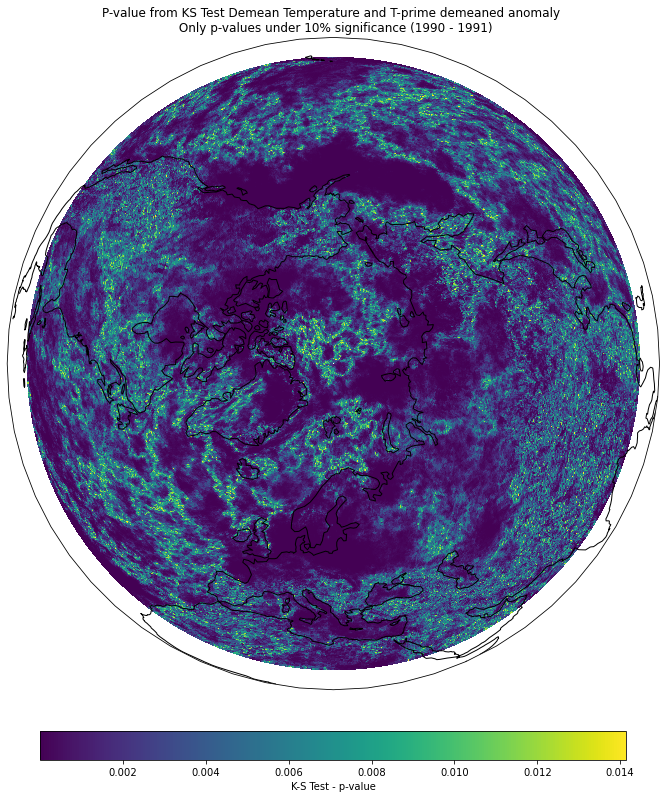

In [164]:
import cartopy.crs as ccrs
import numpy as np

fig = plt.subplots(figsize=(15, 15), facecolor='white')
ax = plt.axes(projection=ccrs.Orthographic(20,90))

p = (ks_grid
     .squeeze()
     #.where(ks_grid < 0.01)
     .plot
     .pcolormesh(
         ax=ax,
         transform=ccrs.PlateCarree(),
         extend='neither',
         cbar_kwargs={'orientation': 'horizontal',
                      'pad': 0.05,
                      'shrink': 0.7,
                      'spacing': 'proportional',
                      'label': 'K-S Test - p-value'
                     }
     )
    )
plt.title('P-value from KS Test Demean Temperature and T-prime demeaned anomaly \n Only p-values under 10% significance (1990 - 1991)')
p.axes.set_global()
p.axes.coastlines()
plt.savefig('ks_test_90_decade.png')

### Histograms for testing

In [210]:
t_prime_grid_test = (
    t_prime_grid
    .unstack('grid')
    .sel(lat=42, lon=-87.5)
    .to_dataframe()
    .reset_index()
)

t_grid_test = (
    t_grid
    .unstack('grid')
    .sel(lat=42, lon=-87.5)
    .to_dataframe()
    .reset_index()
)

t_merge = t_prime_grid_test.merge(
    t_grid_test,
    on=['time', 'lat', 'lon', 'expver']
)

In [211]:
t_merge_melt = pd.melt(t_merge,
        id_vars=['time', 'lat', 'lon', 'expver'],
        value_vars=['dm_t_prime', 't2m']
       )
t_merge_melt

,time,lat,lon,expver,variable,value
0,1990-01-01,42.0,-87.5,1,dm_t_prime,-0.004470
1,1990-01-02,42.0,-87.5,1,dm_t_prime,-0.586999
2,1990-01-03,42.0,-87.5,1,dm_t_prime,1.817902
3,1990-01-04,42.0,-87.5,1,dm_t_prime,4.089819
4,1990-01-05,42.0,-87.5,1,dm_t_prime,0.766656
...,...,...,...,...,...,...
1975,2000-12-27,42.0,-87.5,1,t2m,-8.543732
1976,2000-12-28,42.0,-87.5,1,t2m,-6.898895
1977,2000-12-29,42.0,-87.5,1,t2m,-6.816620
1978,2000-12-30,42.0,-87.5,1,t2m,-3.511505


In [212]:
ks_test_wrapper(t_merge['dm_t_prime'], t_merge['t2m'])

0.0013466606727859946

<AxesSubplot:>

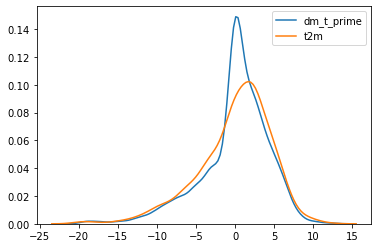

In [213]:
import seaborn as sns 

sns.kdeplot(
    data=t_merge['dm_t_prime'],
    #hue='variable'
)
sns.kdeplot(
    data=t_merge['t2m'],
    #hue='variable'
)

In [209]:
print(t_merge)

          time  expver   lat   lon  dm_t_prime       t2m
0   1990-01-01       1  65.0 -55.0   -4.304434 -3.353760
1   1990-01-02       1  65.0 -55.0   -0.452611  0.060089
2   1990-01-03       1  65.0 -55.0    1.452911  1.377350
3   1990-01-04       1  65.0 -55.0   -1.353503 -1.388916
4   1990-01-05       1  65.0 -55.0    1.373856  0.813049
..         ...     ...   ...   ...         ...       ...
985 2000-12-27       1  65.0 -55.0    6.042930  4.351776
986 2000-12-28       1  65.0 -55.0    4.087522  2.296417
987 2000-12-29       1  65.0 -55.0    3.034480  1.347473
988 2000-12-30       1  65.0 -55.0    2.432885  0.969604
989 2000-12-31       1  65.0 -55.0    0.884534 -0.828400

[990 rows x 6 columns]
